In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [23]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [24]:
# ML Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Attention
from tensorflow.keras.optimizers import Adam


In [25]:
# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [26]:
# Time Series Split
from sklearn.model_selection import TimeSeriesSplit


In [27]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100.0 - (100.0 / (1.0 + rs))

def compute_macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = series.ewm(span=fastperiod, adjust=False).mean()
    ema_slow = series.ewm(span=slowperiod, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signalperiod, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def compute_ma(series, window=20):
    return series.rolling(window=window).mean()

In [28]:
csv_file = "merged_news_stock_data.csv"
df = pd.read_csv(csv_file, parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.dropna(subset=["Date"], inplace=True)
df.reset_index(drop=True, inplace=True)


In [29]:
df["RSI"] = compute_rsi(df["Close_Price"])
df["MACD_line"], df["MACD_signal"], df["MACD_hist"] = compute_macd(df["Close_Price"])
df["MA20"] = compute_ma(df["Close_Price"])
df.dropna(inplace=True)
df["Close_next"] = df["Close_Price"].shift(-1)
df.dropna(inplace=True)


In [30]:
ts_split = TimeSeriesSplit(n_splits=5)
feature_cols = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20", "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
X = df[feature_cols]
y = df["Close_next"]


In [31]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [32]:
results = {}
for train_index, test_index in ts_split.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, max_depth=5, random_state=42),
        "LightGBM": LGBMRegressor(n_estimators=100, max_depth=5, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
        "SVR": SVR(kernel='rbf')
    }
    
    for model_name, model in models.items():
        results[model_name] = evaluate_model(model, X_train, X_test, y_train, y_test)
    
    # LSTM Model
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=30, batch_size=32, verbose=0)
    y_pred_lstm = lstm_model.predict(np.expand_dims(X_test, axis=-1)).flatten()
    results['LSTM'] = (sqrt(mean_squared_error(y_test, y_pred_lstm)), r2_score(y_test, y_pred_lstm))

for model, (rmse, r2) in results.items():
    print(f"{model}: RMSE = {rmse:.4f}, R² = {r2:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 2658, number of used features: 9
[LightGBM] [Info] Start training from score 122.788794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

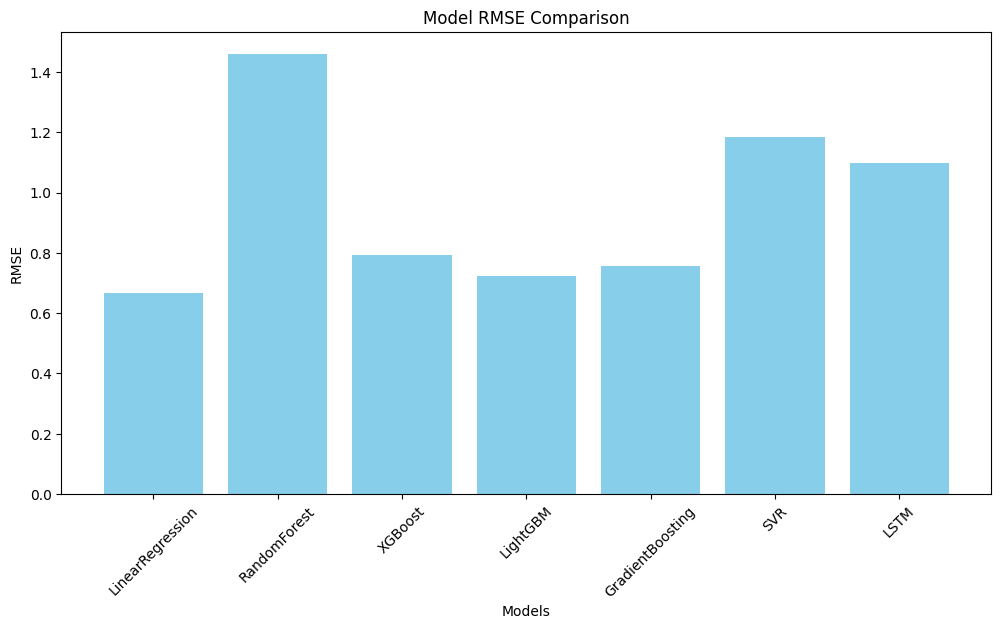

In [33]:
plt.figure(figsize=(12,6))
plt.bar(results.keys(), [rmse for rmse, _ in results.values()], color='skyblue')
plt.title("Model RMSE Comparison")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()


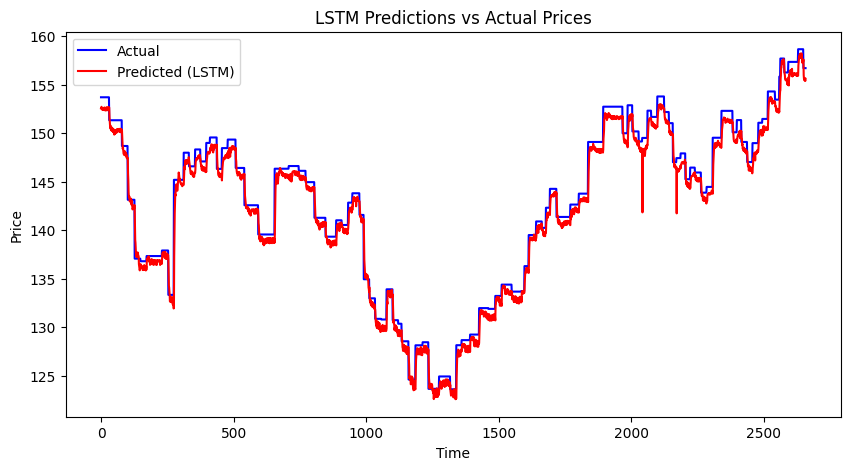

In [34]:

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred_lstm, label='Predicted (LSTM)', color='red')
plt.title("LSTM Predictions vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

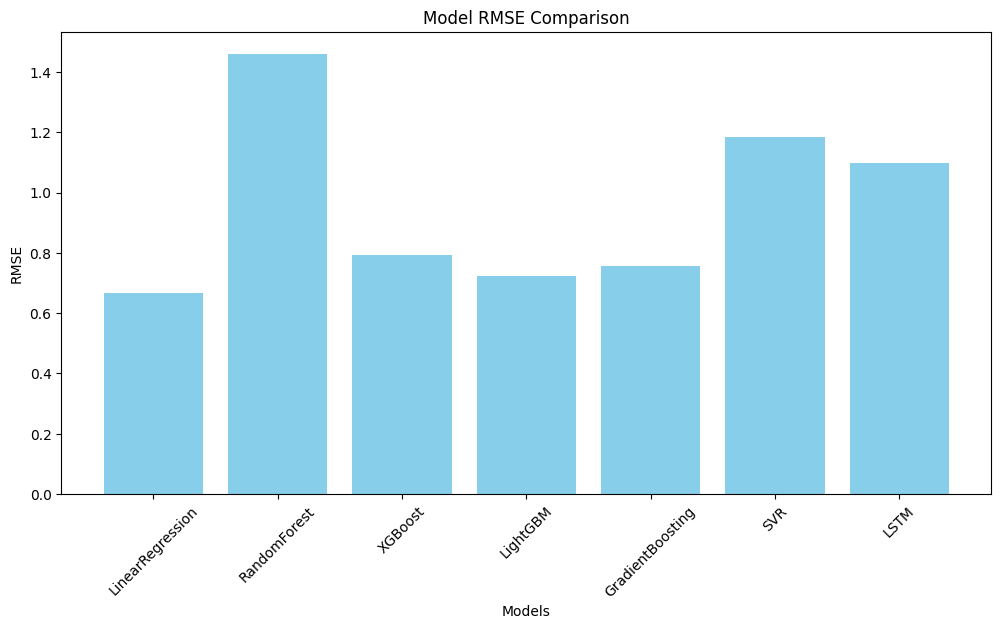

NameError: name 'predictions' is not defined

<Figure size 1000x500 with 0 Axes>

In [35]:
plt.figure(figsize=(12,6))
plt.bar(results.keys(), [rmse for rmse, _ in results.values()], color='skyblue')
plt.title("Model RMSE Comparison")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
for model_name, y_pred in predictions.items():
    plt.plot(y_test.values, label='Actual', color='blue', alpha=0.5)
    plt.plot(y_pred, label=f'Predicted ({model_name})', alpha=0.7)
    plt.title(f"{model_name} Predictions vs Actual Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
